In [25]:
import numpy as np
import pandas as pd
import math

In [26]:
train_df = pd.read_csv('mush_train.data', header=None)
test_df = pd.read_csv('mush_test.data', header=None)
mush_train = train_df.to_numpy()
mush_test = test_df.to_numpy()
print(mush_train.shape, mush_test.shape)
X_train = mush_train[:, 1:]
Y_train = mush_train[:, 0]
X_test = mush_test[:, 1:]
Y_test = mush_test[:, 0]
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(4712, 23) (3412, 23)
(4712, 22) (4712,) (3412, 22) (3412,)


9


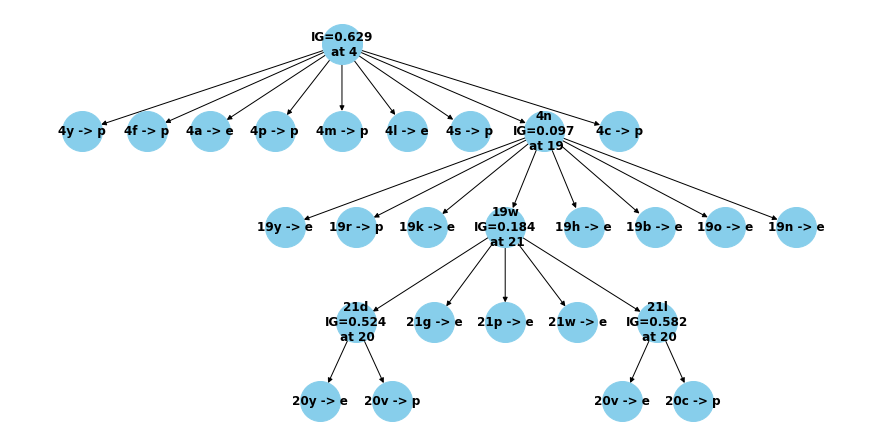

In [27]:
class Node:
    def __init__(self, X, Y, parent, isInternal=True, branched_at=None):
        self.X = X
        self.Y = Y
        self.parent = parent
        self.isInternal = isInternal
        self.child = []
        self.IG = 0
        self.branched_at = branched_at

        if len(set(Y)) == 1:
            self.leaf = True
            self.label = Y[0]
        else:
            self.leaf = False
            self.label = 'not a leaf'
        
        if (parent == None or isInternal) and not self.leaf:
            self.branch()
        
    def cond_entropy(self, xi):
        H_YXi = 0

        for cat in set(self.X[:, xi]):
            Y_cat = self.Y[np.where(self.X[:, xi] == cat)]
            e = len(np.where(Y_cat == 'e')[0]) / Y_cat.shape[0]
            p = len(np.where(Y_cat == 'p')[0]) / Y_cat.shape[0]
            H_YXi -= (Y_cat.shape[0] / self.Y.shape[0]) * (np.log(e ** e) + np.log(p ** p))

        return H_YXi
    
    def branch(self):
        e = len(np.where(self.Y == 'e')[0]) / self.Y.shape[0]
        p = len(np.where(self.Y == 'p')[0]) / self.Y.shape[0]
        H_Y = -(np.log(e ** e) + np.log(p ** p))

        if self.branched_at == None:
            max_gain = 0

            for xi in range(self.X.shape[1]):
                H_Yxi = self.cond_entropy(xi)
                IG = H_Y - H_Yxi

                if IG > max_gain or (IG == max_gain and self.branched_at < xi):
                    max_gain = IG
                    self.branched_at = xi
        else:
            max_gain = H_Y = self.cond_entropy((self.branched_at))
        
        self.IG = max_gain
        self.label = 'IG=' + str(np.round(max_gain, 3)) + '\n at ' + str(self.branched_at)

        for cat in set(self.X[:, self.branched_at]):
            X_c = self.X[np.where(self.X[:, self.branched_at] == cat)[0], :]
            Y_c = self.Y[np.where(self.X[:, self.branched_at] == cat)[0]]
            new_node = Node(X_c, Y_c, self, self.isInternal)
            self.child.append(new_node)

import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

def plot_tree(main_node, index, dim):
    def dfs(mnode, pre_index):
        for node in mnode.child:
            index = node.label

            if index in {'e', 'p'}:
                index = str(mnode.branched_at) + node.X[0, mnode.branched_at] + ' -> ' + index
            else:
                index = str(mnode.branched_at) + node.X[0, mnode.branched_at] + '\n' + index
        
            Graph.add_node(index)
            Graph.add_edge(pre_index, index)
            dfs(node, index)

    Graph = nx.DiGraph()
    Graph.add_node(main_node.label)
    dfs(main_node, index)
    pos = graphviz_layout(Graph, prog='dot')
    plt.figure(figsize=dim)
    nx.draw(Graph, pos, with_labels=True, font_weight='bold', node_color='skyblue', alpha=1, node_size=1600)
    plt.show()

main_node = Node(X_train, Y_train, None)
print(len(main_node.child))
plot_tree(main_node, main_node.label, [12, 6])

In [31]:
def predict(X, main_node):
  Y_pred = []

  for i in range(X.shape[0]):
    cur_node = main_node

    while True:
      if cur_node.label in set(Y_train):
        Y_pred.append(cur_node.label)
        break
      else:
        flag = 0

        for node in cur_node.child:
          check = list(set(node.X[:, cur_node.branched_at]))[0]

          if X[i, cur_node.branched_at] == check:
            cur_node = node
            flag = 1
            break

        if flag == 0:
          Y_pred.append('Not found')
          break
  
  return Y_pred

In [35]:
(predict(X_test, main_node) == Y_test).mean()

1.0

In [36]:
predict(X_test[:10, :], main_node)

['p', 'p', 'p', 'e', 'p', 'p', 'p', 'e', 'p', 'e']